In [1]:
import numpy as np
import pylab as pl
from scipy import interpolate

In [2]:
import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = ['SimHei']

## 插值-interpolate

### 一维插值

> **WARNING**

> 高次`interp1d()`插值的运算量很大，因此对于点数较多的数据，建议使用后面介绍的`UnivariateSpline()`。

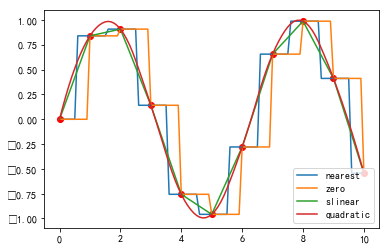

In [3]:
#%fig=`interp1d`的各阶插值
from scipy import interpolate

x = np.linspace(0, 10, 11)
y = np.sin(x)

xnew = np.linspace(0, 10, 101)
pl.plot(x, y, 'ro')
for kind in ['nearest', 'zero', 'slinear', 'quadratic']:
    f = interpolate.interp1d(x, y, kind=kind)  #❶
    ynew = f(xnew)  #❷
    pl.plot(xnew, ynew, label=str(kind))

pl.legend(loc='lower right')

#### 外推和Spline拟合

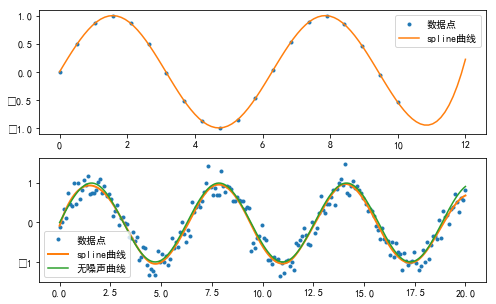

In [4]:
#%fig=使用UnivariateSpline进行插值：外推（上），数据拟合（下）
x1 = np.linspace(0, 10, 20)
y1 = np.sin(x1)
sx1 = np.linspace(0, 12, 100)
sy1 = interpolate.UnivariateSpline(x1, y1, s=0)(sx1)  #❶

x2 = np.linspace(0, 20, 200)
y2 = np.sin(x2) + np.random.standard_normal(len(x2)) * 0.2
sx2 = np.linspace(0, 20, 2000)
spline2 = interpolate.UnivariateSpline(x2, y2, s=8)  #❷
sy2 = spline2(sx2)

pl.figure(figsize=(8, 5))
pl.subplot(211)
pl.plot(x1, y1, ".", label=u"数据点")
pl.plot(sx1, sy1, label=u"spline曲线")
pl.legend()

pl.subplot(212)
pl.plot(x2, y2, ".", label=u"数据点")
pl.plot(sx2, sy2, linewidth=2, label=u"spline曲线")
pl.plot(x2, np.sin(x2), label=u"无噪声曲线")
pl.legend()

In [5]:
print(np.array_str(spline2.roots(), precision=3))

[ 0.053  3.151  6.36   9.386 12.603 15.619 18.929]


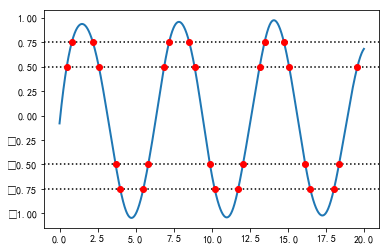

In [6]:
#%fig=计算Spline与水平线的交点
def roots_at(self, v):  #❶
    coeff = self.get_coeffs()
    coeff -= v
    try:
        root = self.roots()
        return root
    finally:
        coeff += v


interpolate.UnivariateSpline.roots_at = roots_at  #❷

pl.plot(sx2, sy2, linewidth=2, label=u"spline曲线")

ax = pl.gca()
for level in [0.5, 0.75, -0.5, -0.75]:
    ax.axhline(level, ls=":", color="k")
    xr = spline2.roots_at(level)  #❸
    pl.plot(xr, spline2(xr), "ro")

#### 参数插值

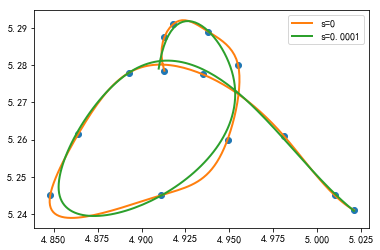

In [7]:
#%fig=使用参数插值连接二维平面上的点
x = [
    4.913, 4.913, 4.918, 4.938, 4.955, 4.949, 4.911, 4.848, 4.864, 4.893,
    4.935, 4.981, 5.01, 5.021
]

y = [
    5.2785, 5.2875, 5.291, 5.289, 5.28, 5.26, 5.245, 5.245, 5.2615, 5.278,
    5.2775, 5.261, 5.245, 5.241
]

pl.plot(x, y, "o")

for s in (0, 1e-4):
    tck, t = interpolate.splprep([x, y], s=s)  #❶
    xi, yi = interpolate.splev(np.linspace(t[0], t[-1], 200), tck)  #❷
    pl.plot(xi, yi, lw=2, label=u"s=%g" % s)

pl.legend()

#### 单调插值

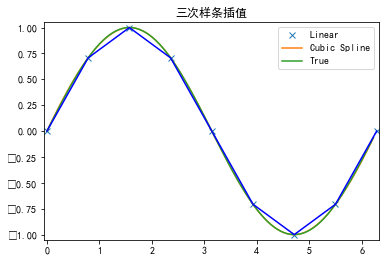

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import interpolate

x = np.arange(0, 2 * np.pi + np.pi / 4, 2 * np.pi / 8)
y = np.sin(x)
tck = interpolate.splrep(x, y, s=0)
xnew = np.arange(0, 2 * np.pi, np.pi / 50)
ynew = interpolate.splev(xnew, tck, der=0)

plt.figure()
plt.plot(x, y, 'x', xnew, ynew, xnew, np.sin(xnew), x, y, 'b')
plt.legend(['Linear', 'Cubic Spline', 'True'])
plt.axis([-0.05, 6.33, -1.05, 1.05])
plt.title('三次样条插值')
plt.show()

### 多维插值

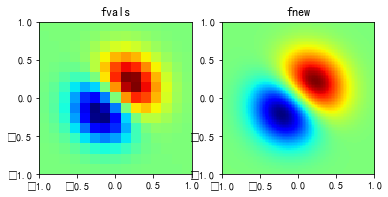

In [9]:
#%fig=使用interp2d类进行二维插值
def func(x, y):  #❶
    return (x + y) * np.exp(-5.0 * (x**2 + y**2))


# X-Y轴分为15*15的网格
y, x = np.mgrid[-1:1:15j, -1:1:15j]  #❷
fvals = func(x, y)  # 计算每个网格点上的函数值

# 二维插值
newfunc = interpolate.interp2d(x, y, fvals, kind='cubic')  #❸

# 计算100*100的网格上的插值
xnew = np.linspace(-1, 1, 100)
ynew = np.linspace(-1, 1, 100)
fnew = newfunc(xnew, ynew)  #❹
#%hide
pl.subplot(121)
pl.imshow(
    fvals,
    extent=[-1, 1, -1, 1],
    cmap=pl.cm.jet,
    interpolation='nearest',
    origin="lower")
pl.title("fvals")
pl.subplot(122)
pl.imshow(
    fnew,
    extent=[-1, 1, -1, 1],
    cmap=pl.cm.jet,
    interpolation='nearest',
    origin="lower")
pl.title("fnew")
pl.show()

#### griddata

> **WARNING**

> `griddata()`使用欧几里得距离计算插值。如果K维空间中每个维度的取值范围相差较大，则应先将数据正规化，然后使用`griddata()`进行插值运算。

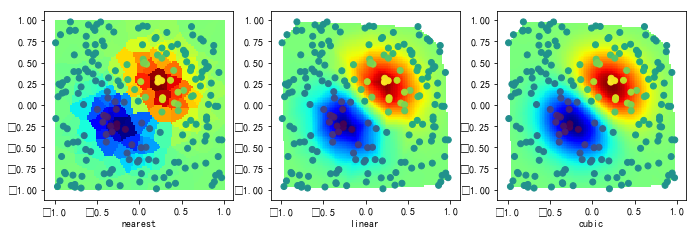

In [10]:
#%fig=使用gridata进行二维插值
# 计算随机N个点的坐标，以及这些点对应的函数值
N = 200
np.random.seed(42)
x = np.random.uniform(-1, 1, N)
y = np.random.uniform(-1, 1, N)
z = func(x, y)

yg, xg = np.mgrid[-1:1:100j, -1:1:100j]
xi = np.c_[xg.ravel(), yg.ravel()]

methods = 'nearest', 'linear', 'cubic'

zgs = [
    interpolate.griddata((x, y), z, xi, method=method).reshape(100, 100)
    for method in methods
]
#%hide
fig, axes = pl.subplots(1, 3, figsize=(11.5, 3.5))

for ax, method, zg in zip(axes, methods, zgs):
    ax.imshow(
        zg,
        extent=[-1, 1, -1, 1],
        cmap=pl.cm.jet,
        interpolation='nearest',
        origin="lower")
    ax.set_xlabel(method)
    ax.scatter(x, y, c=z)

#### 径向基函数插值

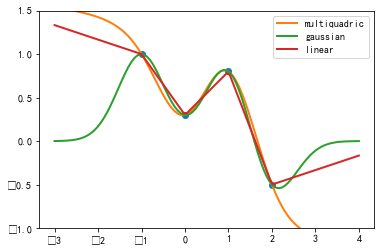

In [11]:
#%fig=一维RBF插值
from scipy.interpolate import Rbf

x1 = np.array([-1, 0, 2.0, 1.0])
y1 = np.array([1.0, 0.3, -0.5, 0.8])

funcs = ['multiquadric', 'gaussian', 'linear']
nx = np.linspace(-3, 4, 100)
rbfs = [Rbf(x1, y1, function=fname) for fname in funcs]  #❶
rbf_ys = [rbf(nx) for rbf in rbfs]  #❷
#%hide
pl.plot(x1, y1, "o")
for fname, ny in zip(funcs, rbf_ys):
    pl.plot(nx, ny, label=fname, lw=2)

pl.ylim(-1.0, 1.5)
pl.legend()

In [12]:
for fname, rbf in zip(funcs, rbfs):
    print (fname, rbf.nodes)

multiquadric [-0.88822885  2.17654513  1.42877511 -2.67919021]
gaussian [ 1.00321945 -0.02345964 -0.65441716  0.91375159]
linear [-0.26666667  0.6         0.73333333 -0.9       ]


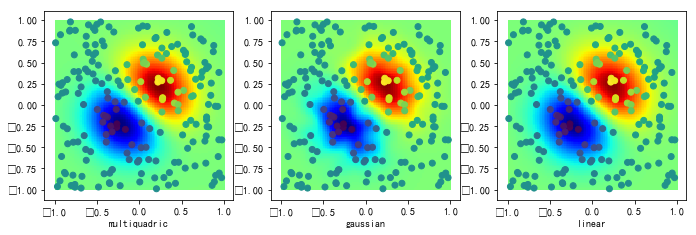

In [13]:
#%fig=二维径向基函数插值
rbfs = [Rbf(x, y, z, function=fname) for fname in funcs]
rbf_zg = [rbf(xg, yg).reshape(xg.shape) for rbf in rbfs]
#%hide
fig, axes = pl.subplots(1, 3, figsize=(11.5, 3.5))
for ax, fname, zg in zip(axes, funcs, rbf_zg):
    ax.imshow(
        zg,
        extent=[-1, 1, -1, 1],
        cmap=pl.cm.jet,
        interpolation='nearest',
        origin="lower")
    ax.set_xlabel(fname)
    ax.scatter(x, y, c=z)

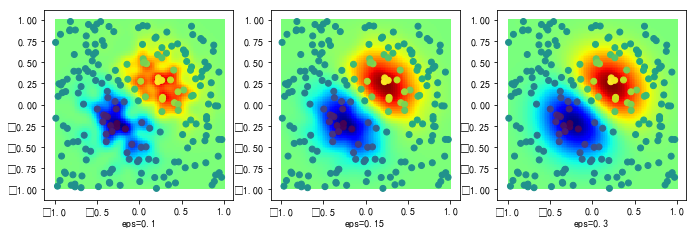

In [14]:
#%fig=`epsilon`参数指定径向基函数中数据点的作用范围
epsilons = 0.1, 0.15, 0.3
rbfs = [Rbf(x, y, z, function="gaussian", epsilon=eps) for eps in epsilons]
zgs = [rbf(xg, yg).reshape(xg.shape) for rbf in rbfs]
#%hide
fig, axes = pl.subplots(1, 3, figsize=(11.5, 3.5))
for ax, eps, zg in zip(axes, epsilons, zgs):
    ax.imshow(
        zg,
        extent=[-1, 1, -1, 1],
        cmap=pl.cm.jet,
        interpolation='nearest',
        origin="lower")
    ax.set_xlabel("eps=%g" % eps)
    ax.scatter(x, y, c=z)